<a href="https://colab.research.google.com/github/GundetiManoj99/Molecule_generation_HMM/blob/main/markov_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install optuna rdkit_pypi deepchem transformers matplotlib tqdm hmmlearn xgboost

In [47]:
import os
from typing import List
import random
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import rdkit.Chem.Descriptors
from hmmlearn.hmm import MultinomialHMM
from hmmlearn.hmm import CategoricalHMM
import xgboost

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Lipinski,Descriptors
import functools

In [48]:
# Create a new directory named 'new_directory'
!mkdir -p datasets

# Move the file 'file-cFr6VmYXiISRDMrj92GFH55R' into 'new_directory'


In [49]:
!mv /content/dataset2.csv datasets/

mv: cannot stat '/content/dataset2.csv': No such file or directory


In [50]:
dataset_path = '/content/datasets'
files = [i for i in os.listdir(dataset_path) if i.endswith('csv')]

all_smiles = set()

for file in files:
    df = pd.read_csv(os.path.join(dataset_path, file))
    all_smiles.update(df.smiles.dropna())

all_smiles = set(smile for smile in all_smiles if ':' not in smile)
print(f"total of {len(all_smiles)} smiles")
print("Sample smiles:")
for count, smile in enumerate(all_smiles):
    print(smile)
    if count > 10:
        break


total of 3082 smiles
Sample smiles:
CC(=O)NCCOC(=O)C(Oc1cccc(C(F)(F)F)c1)c1ccc(Cl)cc1
CCCCCCC(=O)O[C@H]1CC[C@H]2[C@@H]3CC[C@H]4CC(=O)C=C(C)[C@]4(C)[C@H]3CC[C@]12C
O=[N+]([O-])OCC(CO)(CO[N+](=O)[O-])CO[N+](=O)[O-]
O=c1[nH]c2ccccc2n1CCCN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1
Nc1ccc(S(=O)(=O)Nc2ccccc2)cc1
Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1O
COc1cc(C=O)ccc1O
FCC(F)(F)F
COc1cc2ncnc(N3CCN(C(=O)OCC(C)(C)O)CC3)c2cc1OC
CN(C)C(=N)NC(=N)N
O=C([O-])Cc1ccccc1.[Na+]
CC(C(=O)O)c1ccc(N2Cc3ccccc3C2=O)cc1


In [51]:
# Need to patch deepchem first per https://github.com/deepchem/deepchem/issues/2519
import re, importlib
deepchem_root_path = importlib.util.find_spec('deepchem').origin
smiles_tokenizer_path = os.path.join(os.path.dirname(deepchem_root_path), "feat", "smiles_tokenizer.py")

with open(smiles_tokenizer_path, "r") as inp:
    file_contents = inp.read()

with open(smiles_tokenizer_path, "w") as outp:
    for line in file_contents.split("\n"):
        outp.write(re.sub("max_len\(\s\)", "model_max_length", line) + "\n")

In [52]:
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

In [53]:
class SmilesEncoder():
    def __init__(self):
        # Download Deepchem's vocabulary file if we don't already have it
        vocab_url = "https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/tests/data/vocab.txt"
        self.vocab_path = "/content/vocab.txt"
        if not os.path.exists(self.vocab_path):
            with open(vocab_path, "wb") as outp:
                download = urllib.request.urlopen(vocab_url)
                outp.write(download.read())
                # Also, make sure colons are in our vocabulary
                outp.write(b"\n:")

        self.tokenizer = SmilesTokenizer(self.vocab_path)
        self.inversion_dict = {value: key for key, value in self.tokenizer.vocab.items()}

        self.ignored_range = list(range(self.tokenizer.vocab['[PAD]'], self.tokenizer.vocab['[MASK]']))

    def transform(self, X: str) -> List[int]:
        # Don't care about the start/end (X)
        tokenized = self.tokenizer.encode(X)
        return tokenized

    def inverse_transform(self, X: List[int]) -> str:
        sep = self.tokenizer.vocab['[SEP]']
        if sep in X:
            end_index = np.random.choice(np.where(X == sep)[0])
            if end_index <= 1:
                end_index = -1
        else:
          end_index = -1
        result = "".join(self.inversion_dict[i] for i in X[1:end_index] if i not in self.ignored_range)
        return result
enc = SmilesEncoder()

In [54]:
encoded =list(map(enc.transform,all_smiles))
np.random.shuffle(encoded)

In [55]:
def objective(n_states:int)->int:
  n_subsamples=16
  subsample_size =128
  total=0
  for n in tqdm.trange(n_subsamples):
    model= CategoricalHMM(n_states, verbose=False, n_iter=64)
    x=np.concatenate([random.choice(encoded) for _ in range(subsample_size)]).reshape(-1,1)
    model.fit(x)
    total+=model.score(x)
  mean=total/n_subsamples
  return mean
vals=[]
n_max =4
for n in range(1, n_max+1):
  print(f"{n} states",flush=True)
  vals.append(objective(n))

1 states


100%|██████████| 16/16 [00:00<00:00, 107.23it/s]

2 states



100%|██████████| 16/16 [00:02<00:00,  6.77it/s]

3 states



100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

4 states



100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


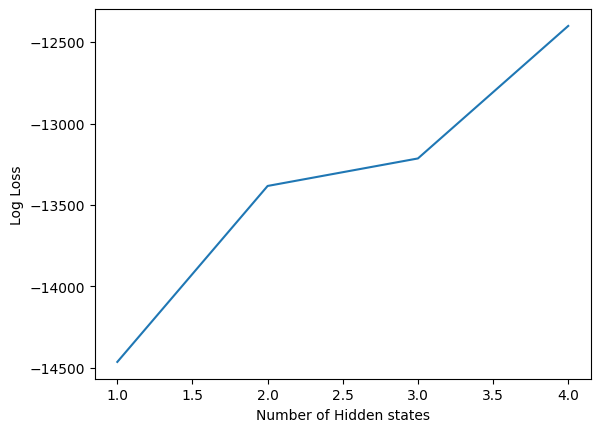

In [56]:
plt.plot(list(range(1,len(vals)+1)),vals)
plt.xlabel("Number of Hidden states")
plt.ylabel("Log Loss")
plt.show()
plt.close()

In [57]:
best_n, best_loss =max(enumerate(vals,1), key=lambda i: i[0])
print(f"Training with {best_n} hidden states")
model = CategoricalHMM(best_n, verbose=True, n_iter=1024)
model.fit(np.concatenate(encoded).reshape(-1, 1))


Training with 4 hidden states


         1 -812779.25862413             +nan
         2 -346846.03786134 +465933.22076279
         3 -336316.41744710  +10529.62041424
         4 -324864.00170983  +11452.41573727
         5 -318757.67601013   +6106.32569970
         6 -315500.15677939   +3257.51923074
         7 -313465.30842460   +2034.84835479
         8 -312157.29672961   +1308.01169499
         9 -311176.72029406    +980.57643555
        10 -310284.08979825    +892.63049582
        11 -309408.93910927    +875.15068897
        12 -308578.16867610    +830.77043317
        13 -307850.08850290    +728.08017320
        14 -307252.84648337    +597.24201953
        15 -306773.45434234    +479.39214103
        16 -306385.90487484    +387.54946750
        17 -306070.95582167    +314.94905317
        18 -305812.47977989    +258.47604178
        19 -305592.09849385    +220.38128604
        20 -305400.77835871    +191.32013514
        21 -305248.79927000    +151.97908871
        22 -305144.57343082    +104.22583918
        23

CategoricalHMM(n_components=4, n_features=391, n_iter=1024,
               random_state=RandomState(MT19937) at 0x7EDA7597E240,
               verbose=True)

In [58]:
import pickle
with open("/content/markov1.pkl","wb") as outp:
  pickle.dump(model,outp)

In [59]:
def generate_molecules(min_heavy_atoms: int, max_heavy_atoms: int, num_mols: int, verbose: bool = True) -> List[rdkit.Chem.Mol]:
    pred_mols = []
    while len(pred_mols) < num_mols:
        sample, _ = model.sample(max_heavy_atoms)
        sample = sample.T[0]
        pred = enc.inverse_transform(sample)
        print(pred)
        try:
            mol = Chem.MolFromSmiles(pred)
        except:
            mol = None
        if mol and mol.GetNumAtoms() >= min_heavy_atoms:
            pred_mols.append(mol)
            if verbose:
                print(f"Found {len(pred_mols)} molecules. New molecule has weight {np.round(Chem.Descriptors.MolWt(mol), 3)} amu")

    return pred_mols



)1
C)
(=
N(
O(
CN
Found 1 molecules. New molecule has weight 31.058 amu
5C
Sc
NC
Found 2 molecules. New molecule has weight 31.058 amu
O)
C=
O(
2O
)C
(N
)C
C1
)
[C@H]C
Found 3 molecules. New molecule has weight 28.054 amu
CC
Found 4 molecules. New molecule has weight 30.07 amu
C)
=O
7C
([C@@]
C
N)
c(
C)
1=
)c
)O
OC
Found 5 molecules. New molecule has weight 32.042 amu


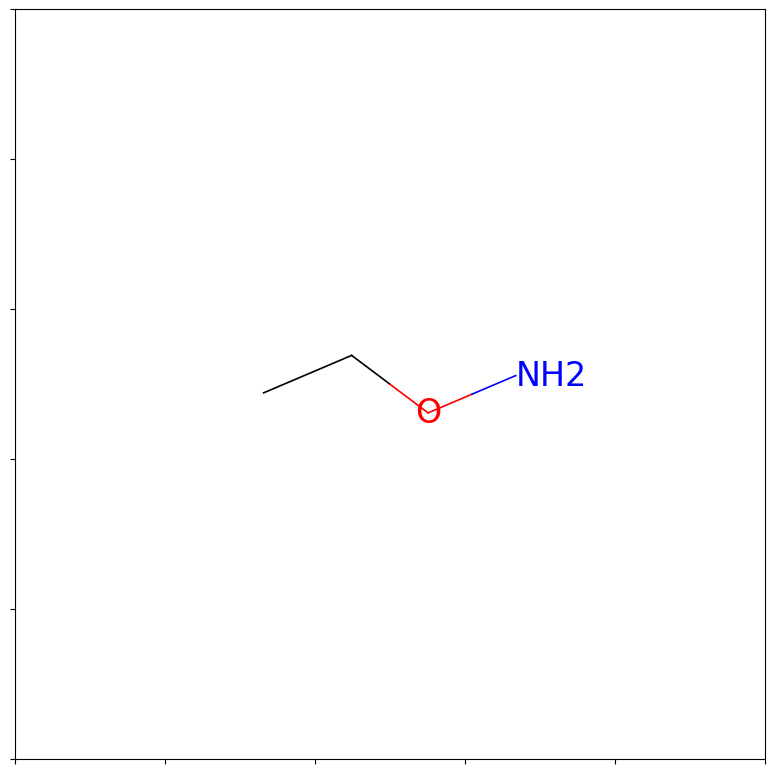

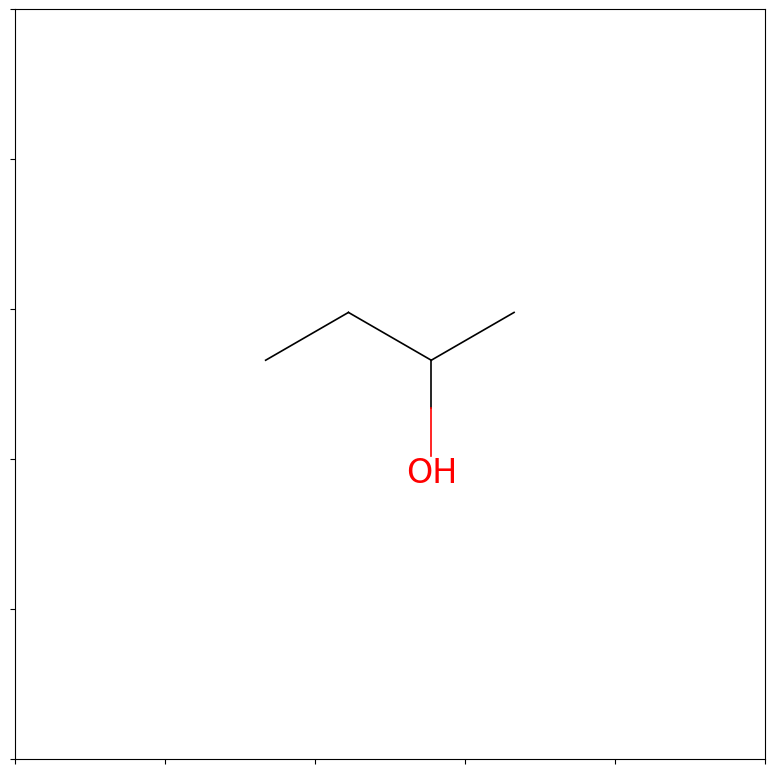

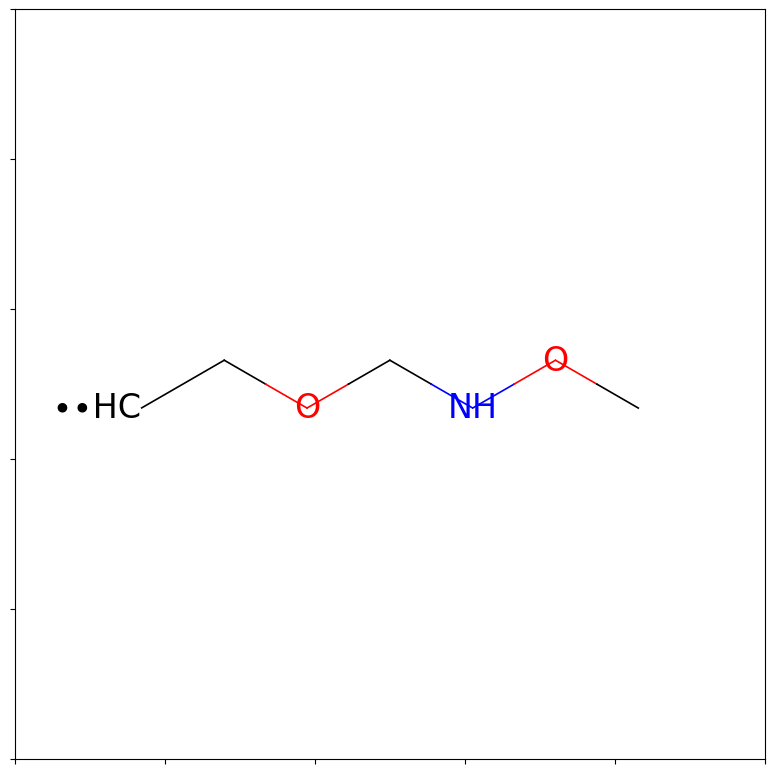

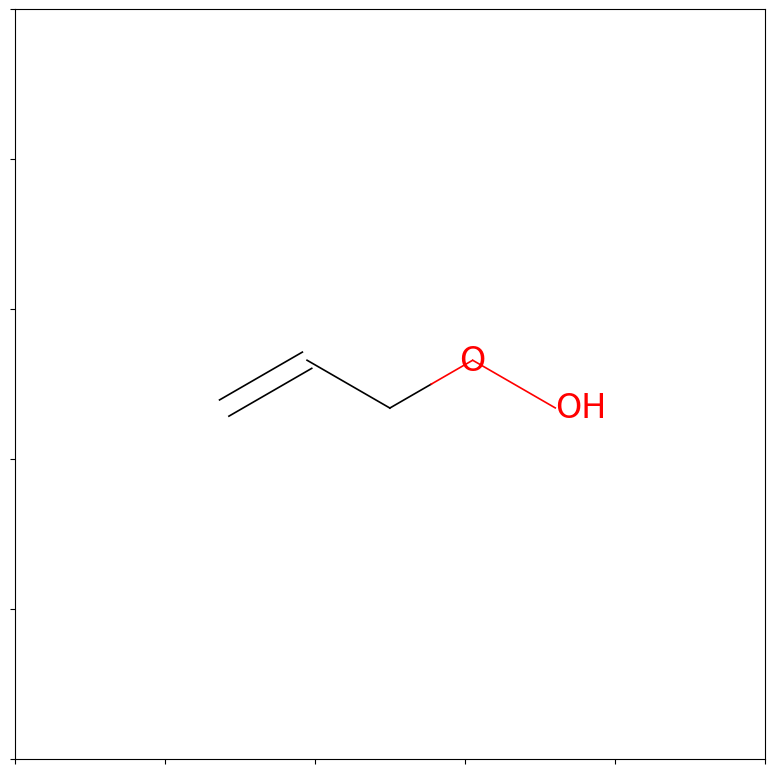

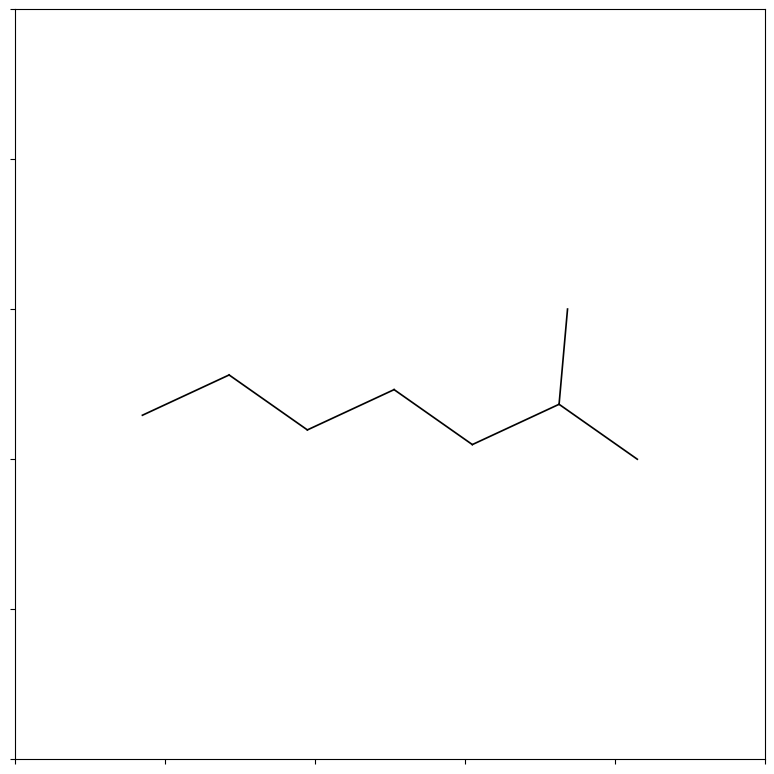

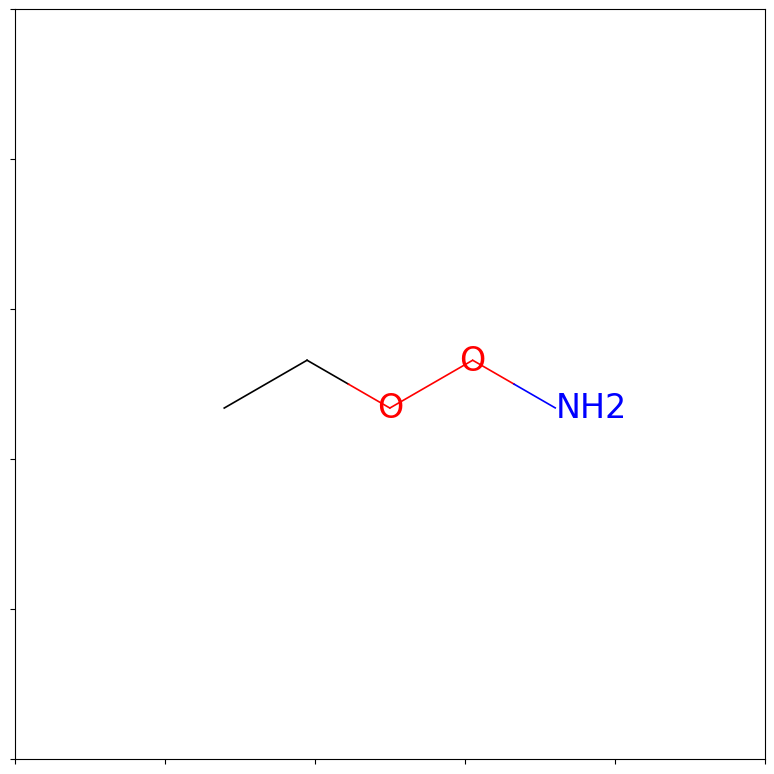

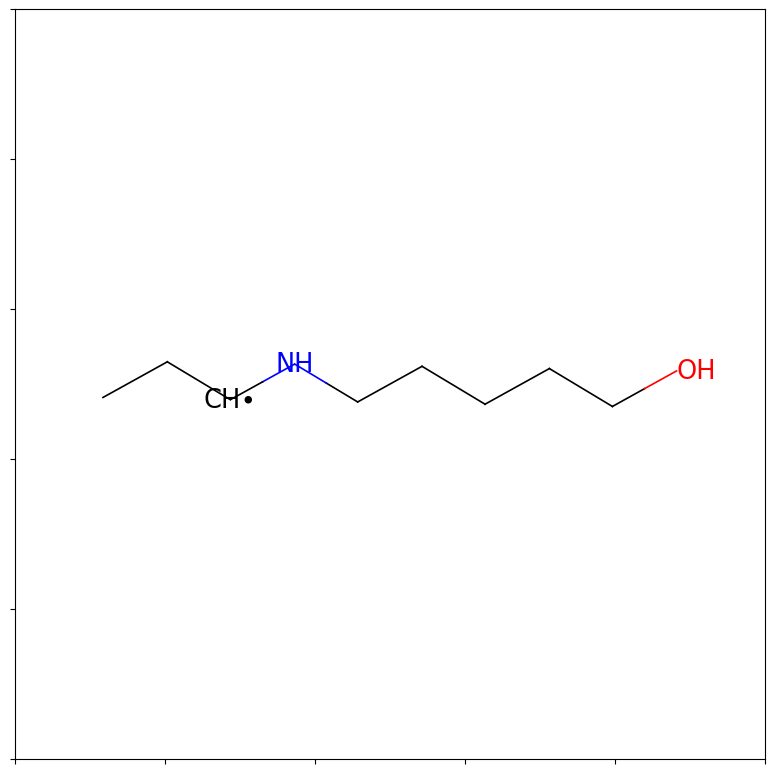

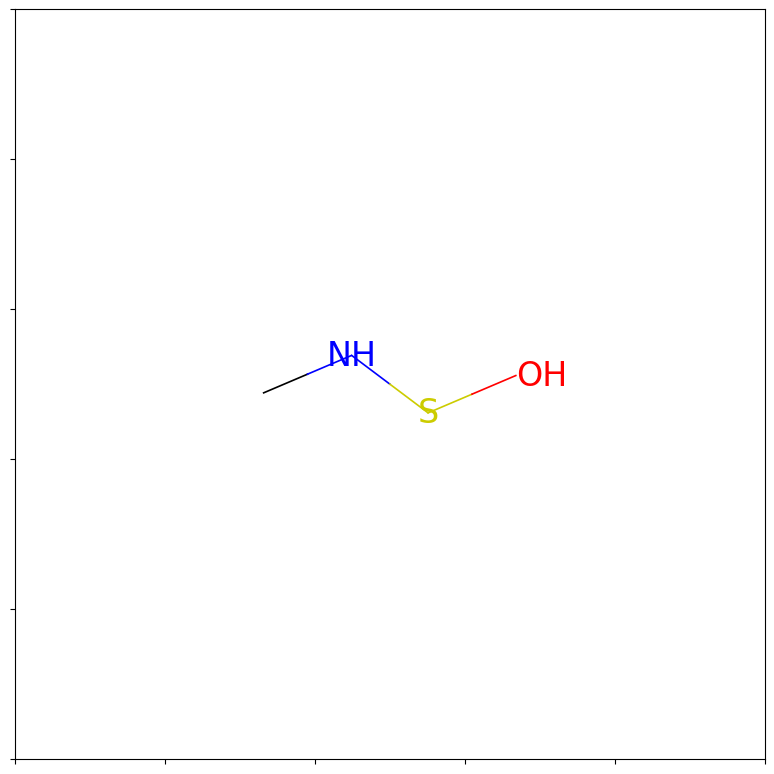

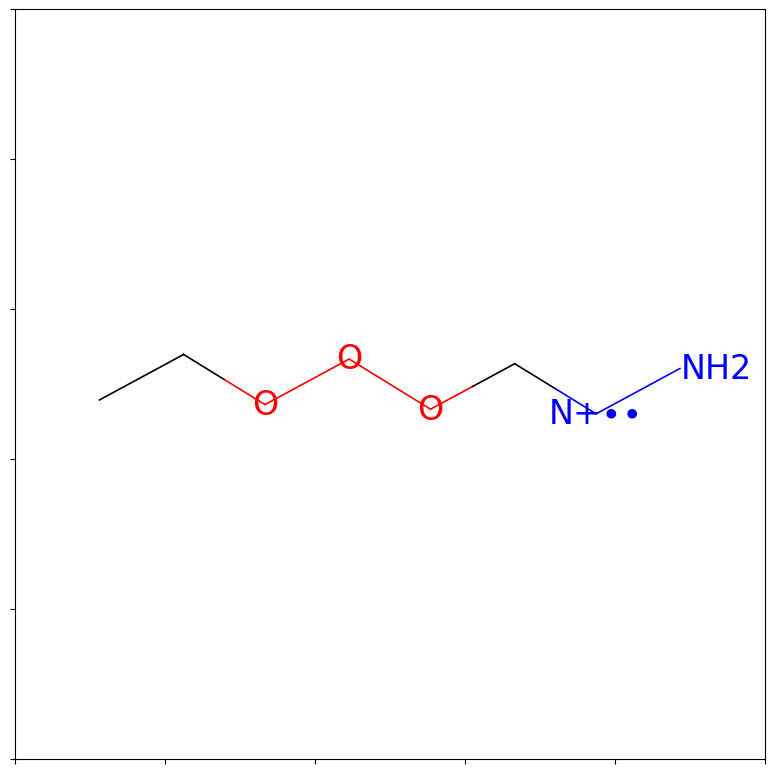

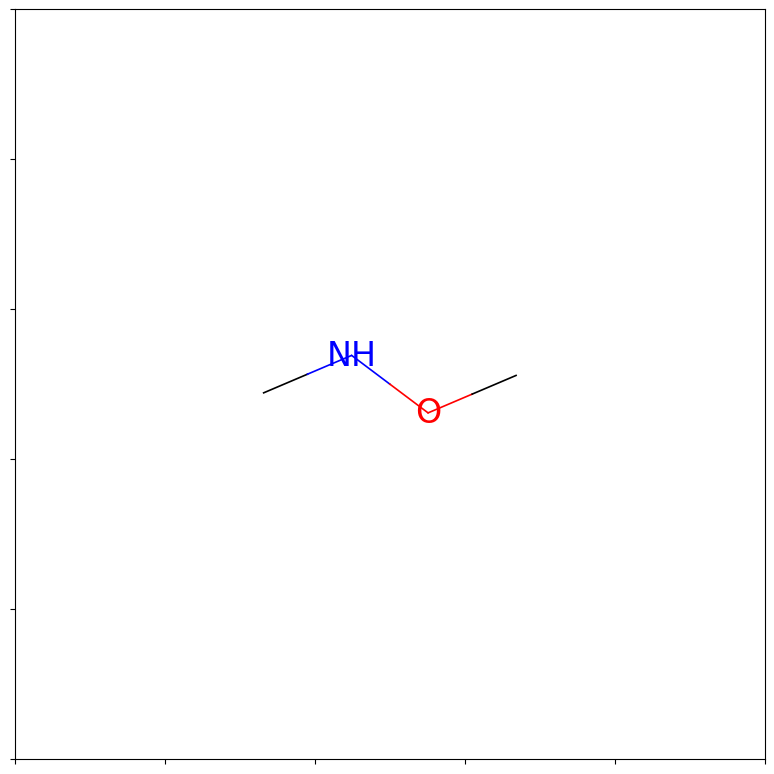

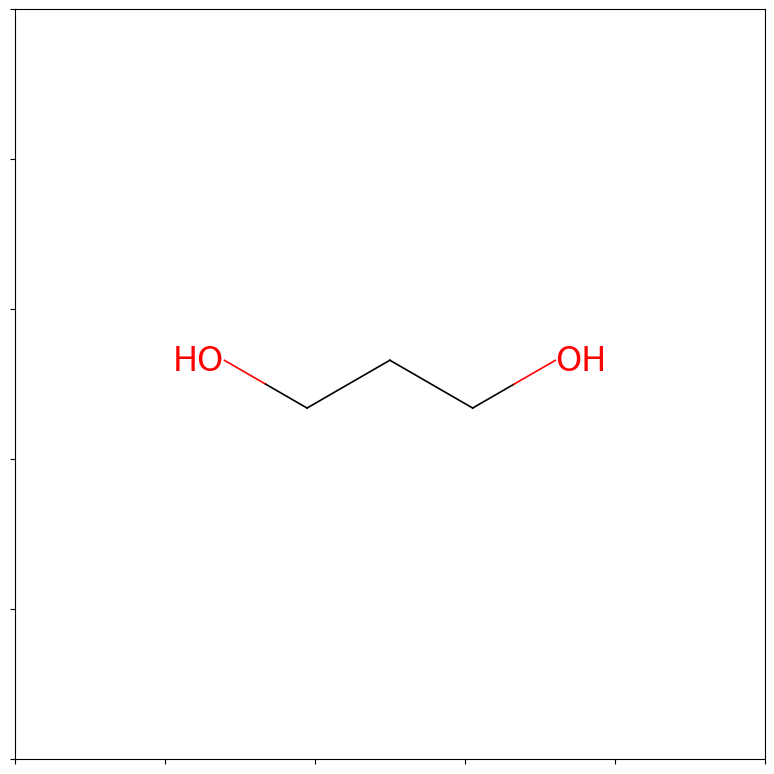

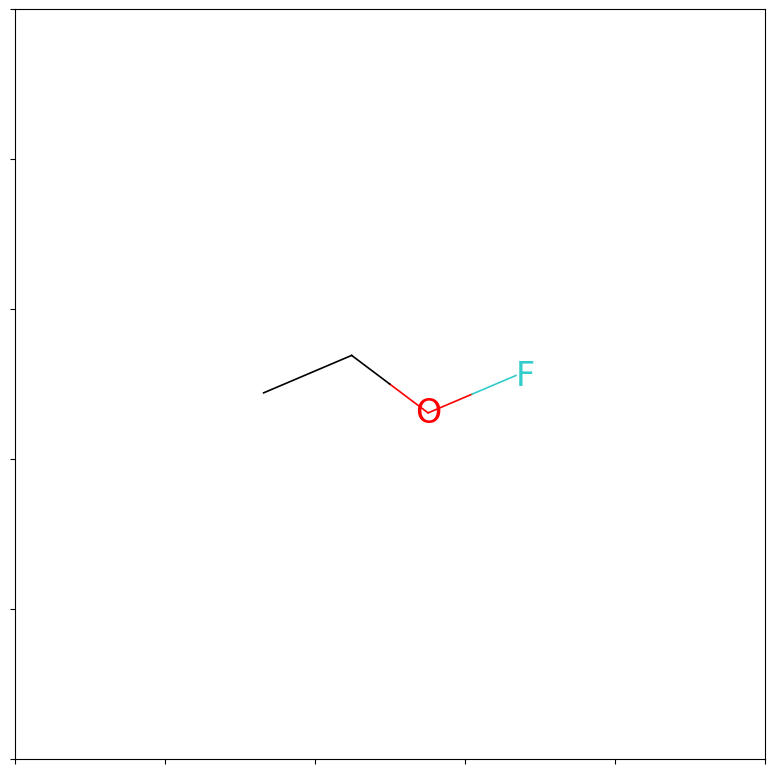

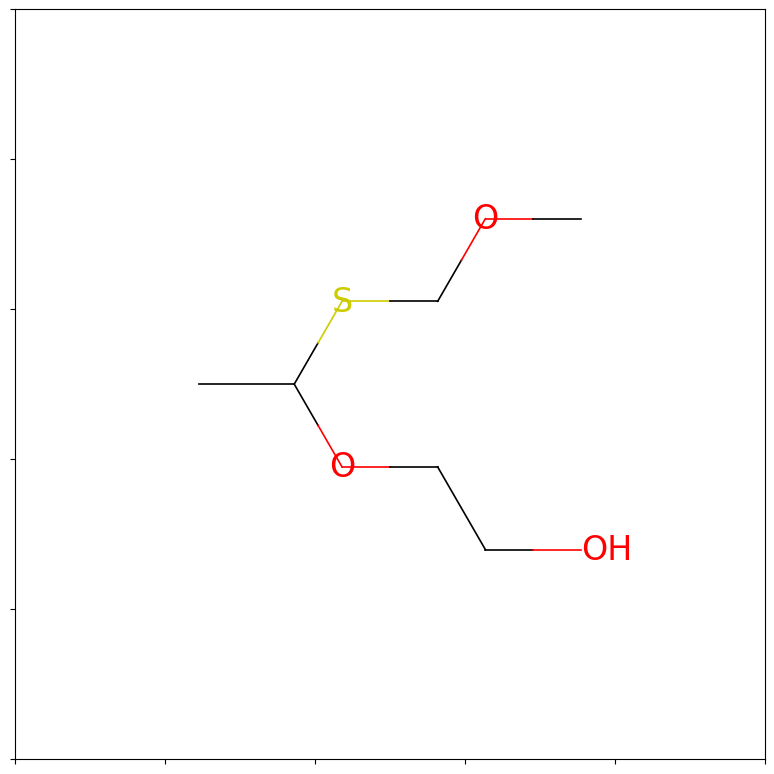

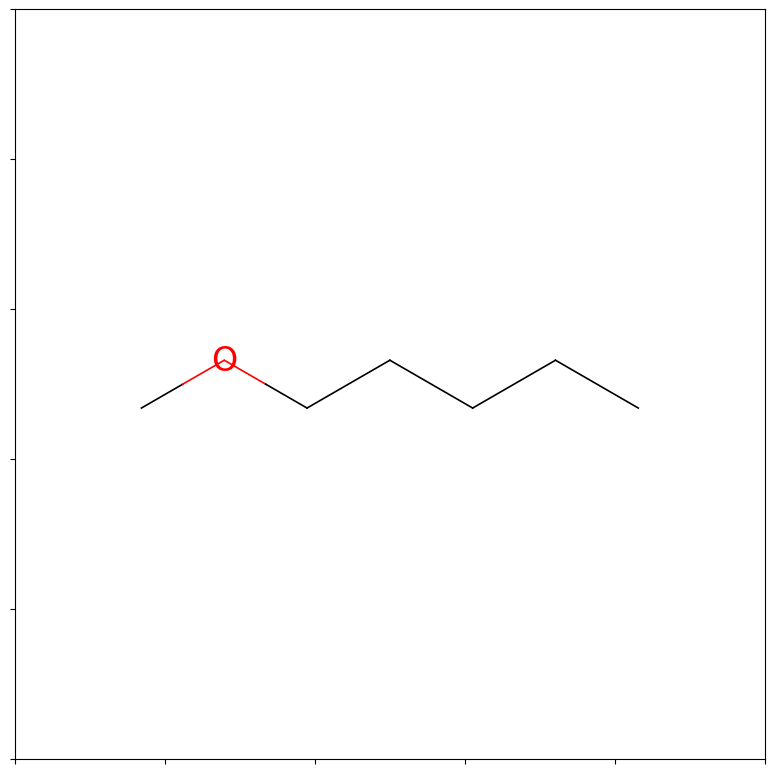

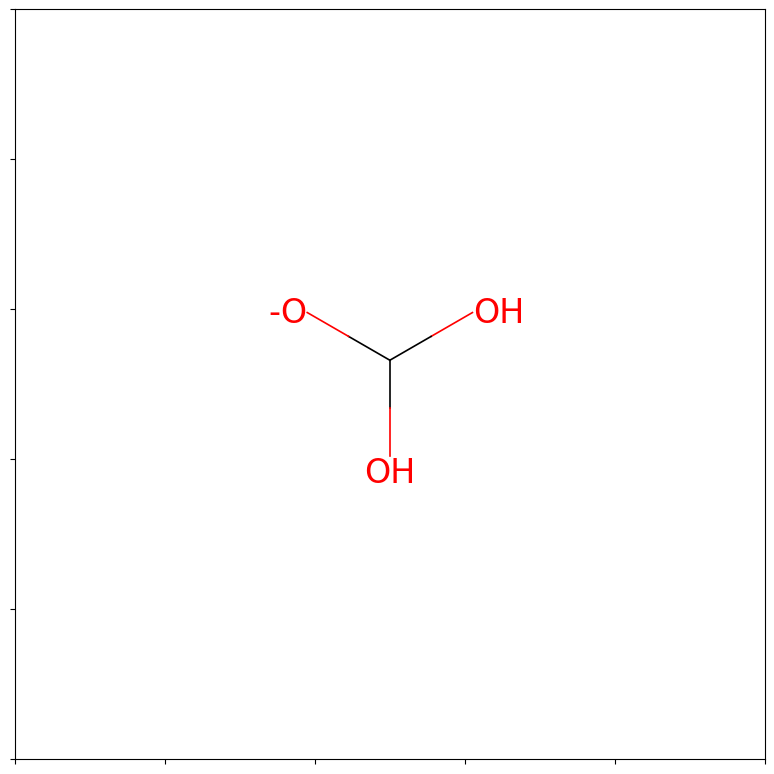

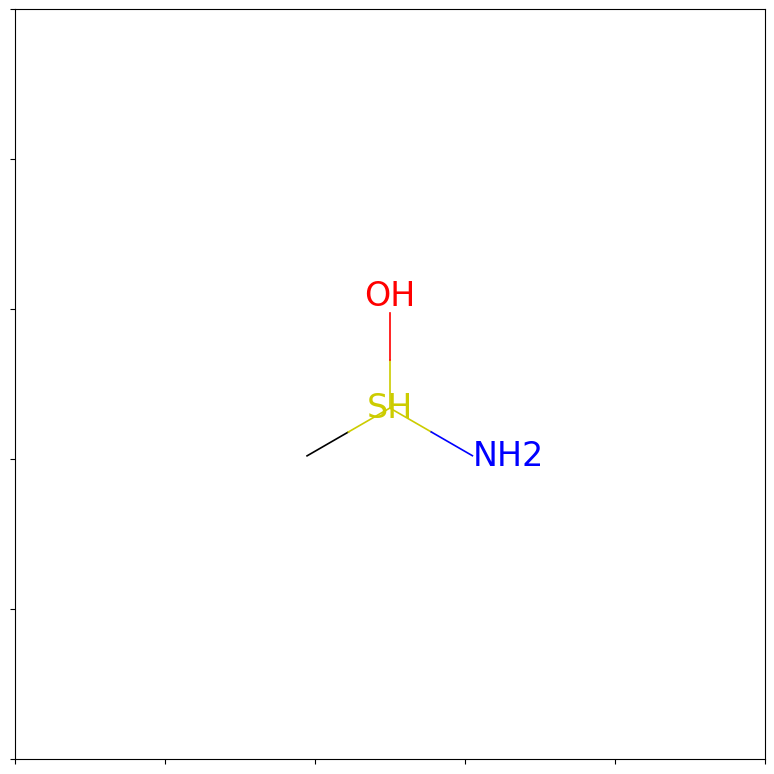

In [63]:
generate_molecules(min_heavy_atoms=2, max_heavy_atoms=4, num_mols=5, verbose=True)
for mol in generated_molecules:
    Chem.Draw.MolToMPL(mol)
    plt.show()
    plt.close()

In [60]:
def load_model(file_path: str):
    with open(file_path, "rb") as inp:
        return pickle.load(inp)

# Load the model
pipeline = load_model("markov1.pkl")

In [61]:
from rdkit.Chem import Lipinski, Descriptors
from rdkit import Chem

def predict_bitter_from_smiles(smiles, model= pipeline):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return False  # Skip invalid molecules
    descriptors = [
        Lipinski.NumAromaticRings,
        Lipinski.NumHAcceptors,
        Lipinski.NumHDonors,
        Descriptors.MolWt,
        Descriptors.MinPartialCharge,
        Descriptors.MaxPartialCharge,
        Descriptors.FpDensityMorgan1,
        Descriptors.FpDensityMorgan2,
        Descriptors.FpDensityMorgan3,
    ]
    features = [descriptor(mol) for descriptor in descriptors]
    result = model.predict([features])
    return result[0]  # Assuming the model returns a list-like object and we need the first element




In [ ]:
bitter_candidates = []
n_desired_candidates = 8

while len(bitter_candidates) < n_desired_candidates:
    generated_molecules = generate_molecules(min_heavy_atoms=4, max_heavy_atoms=30, num_mols=16, verbose=False)
    smiles_list = [Chem.MolToSmiles(mol) for mol in generated_molecules if mol is not None]  # Ensure valid SMILES
    bitter_candidates += list(filter(predict_bitter_from_smiles, smiles_list))

print(bitter_candidates)